In [13]:
import numpy as np
import tensorflow as tf
import cv2
import matplotlib.pyplot as plt
%matplotlib inline

In [14]:
def load_graph(model_file):
  graph = tf.Graph()
  graph_def = tf.GraphDef()

  with open(model_file, "rb") as f:
    graph_def.ParseFromString(f.read())
  with graph.as_default():
    tf.import_graph_def(graph_def)

  return graph

graph = load_graph('output_graph.pb')
# with tf.gfile.FastGFile('output_graph.pb') as f:
#     graph_def = tf.GraphDef()
#     graph_def.ParseFromString(f.read())
#     _ = tf.import_graph_def(graph_def, name='')
# with tf.Session() as sess: 
#     saver = tf.train.import_meta_graph('output_graph.pb')
# #     saver.restore(sess, tf.train.latest_checkpoint('models/detect'))

#     graph = tf.get_default_graph()
#     x = graph.get_tensor_by_name('x_value:0')
#     predictions = graph.get_tensor_by_name('predictions:0')
#     probabilities = graph.get_tensor_by_name('Softmax:0')
#     res = process_image(test_img_1, sess, x, predictions, probabilities)
    
# plt.imshow(res)

In [15]:
def load_labels(label_file):
    label = []
    proto_as_ascii_lines = tf.gfile.GFile(label_file).readlines()
    for l in proto_as_ascii_lines:
    label.append(l.rstrip())
    return label

labels = load_labels('output_labels.txt')
print(labels)

['green', 'red', 'yellow', 'none']


[ 0.4737359   0.02542987  0.49946234  0.00137185]
yellow 0.499462
green 0.473736
red 0.0254299
none 0.00137185


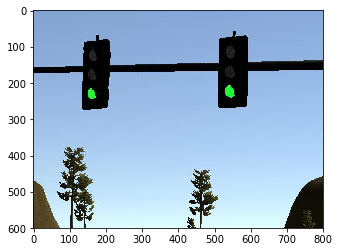

In [51]:
def normalize(img, beta=255):
    cv2.normalize(img, img, alpha=0, beta=beta, norm_type=cv2.NORM_MINMAX)
    
def prepare_image(file_name):
    img = cv2.imread(file_name)
    img = cv2.resize(img, (input_width, input_height))
    
    normalize(img)
    return img

def read_tensor_from_image_file(file_name, input_height=299, input_width=299):
    input_name = "file_reader"
    output_name = "normalized"

    img = prepare_image(file_name)
    
    casted = tf.reshape(img, (-1, input_width, input_height, 3))

    sess = tf.Session()
    result = sess.run(casted)

    return result

file_name = "tmp/Notred_191.jpg"

input_height = 224
input_width = 224
input_mean = 156
input_std = 156

input_layer = "input"
output_layer = "final_result"

input_name = "import/" + input_layer
output_name = "import/" + output_layer
input_operation = graph.get_operation_by_name(input_name);
output_operation = graph.get_operation_by_name(output_name);

t = read_tensor_from_image_file(file_name,
                                  input_height=input_height,
                                  input_width=input_width)

with tf.Session(graph=graph) as sess:
    results = sess.run(output_operation.outputs[0],
                      {input_operation.outputs[0]: t})

results = np.squeeze(results)
top_k = results.argsort()[-5:][::-1]
print(results)
for i in top_k:
    print(labels[i], results[i])
    
img = cv2.imread(file_name)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(img)